In [1]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import time
import pickle
import warnings

# methods
from gaccord import GraphicalAccord, GraphicalConcord
from inverse_covariance import QuicGraphicalLasso
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri

# utils
import sys
sys.path.append('../utils')
from utils import standardize, partial_corr, tp_fp, mcc, precision_recall, pseudo_BIC, gauss_BIC, proj_precision_mat, newton_one_step
from generate_graphs import generate_erdos_renyi, generate_data

In [2]:
# select graph structure = ['hub_network', 'erdos_renyi']
graph_structure = 'erdos_renyi'

### Generate graph and data

In [3]:
if graph_structure == 'hub_network':
    # we use pre-made hub-network graph structure, which was constructed by the following procedure:
    # (1) create a Barabasi-Albert scale-free graph
    # (2) randomly choose 5% of the nodes to be hub nodes
    # (3) for each hub node, construct a complete sub-graph (clique)
    Skel = np.genfromtxt('../data/hub_network_structure.txt', delimiter=',')

    n, p = 500, 1000
    n_prop_to_p = [0.5]
    random_state = 2023
    lower_weight, upper_weight = 0.5, 1.0

    # projection method
    np.random.seed(random_state)
    edge_weights = np.random.uniform(low=lower_weight, high=upper_weight, size=(p,p))
    edge_signs = np.random.choice([-1,1], size=(p,p))
    Theta = np.multiply(edge_weights, edge_signs)
    Theta = np.multiply(Skel, Theta)
    Theta = np.tril(Theta) + np.tril(Theta).T
    nz_indx = np.nonzero(Theta)
    for i in range(100):
        Theta = proj_precision_mat(Theta, nz_indx)
        if np.linalg.cond(Theta) < 20:
            break

    Theta = np.real(Theta)
    # spread diagonal of precision matrix
    spread_diag=[1, 3]
    d = np.random.uniform(spread_diag[0], spread_diag[1], p)
    Theta = np.diag(d) @ Theta @ np.diag(d)
    Rho = partial_corr(Theta)
    Sigma = np.linalg.inv(Theta)

    Xs = generate_data(p, n_prop_to_p, Sigma, N=1, standardize=False, random_state=2023)
    X = Xs[0]
    X_std = standardize(X)

elif graph_structure == 'erdos_renyi':
    n, p = 500, 1000
    n_prop_to_p = [0.5]
    Theta, Sigma = generate_erdos_renyi(p, type='proj', edge_prob=0.01, lower_weight=0.5, upper_weight=1.0, spread_diag=[1, 3], random_state=2023)
    Rho = partial_corr(Theta)

    Xs = generate_data(p, n_prop_to_p, Sigma, N=1, standardize=False, random_state=2023)
    X = Xs[0]
    X_std = standardize(X)

### Run ACCORD

In [4]:
accord_edges, accord_precs, accord_recalls, accord_mccs = [], [], [], []
accord_p_bics, accord_ep_bics_02, accord_g_bics = [], [], []

S = np.matmul(X_std.T, X_std)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)
if graph_structure == 'hub_network':
    lams_accord = lams[::-1][15:27]
elif graph_structure == 'erdos_renyi':
    lams_accord = lams[::-1][8:20]

random_state = 2023
np.random.seed(random_state)
for lam in lams_accord:
    # ACCORD
    model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=100)
    model.fit(X_std)
    Omega_hat = model.omega_.toarray()
    Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))
    
    accord_p_bics.append(pseudo_BIC(X_std, Theta_hat, modified=False))
    accord_ep_bics_02.append(pseudo_BIC(X_std, Theta_hat, modified=True, gamma=0.2))
    accord_g_bics.append(gauss_BIC(X_std, Theta_hat))
    
    accord_edges.append((len(np.flatnonzero(Theta_hat))-p)/2)
    prec, recall = precision_recall(Theta, Theta_hat)
    accord_precs.append(prec)
    accord_recalls.append(recall)
    accord_mccs.append(mcc(Theta, Theta_hat))

### Run ACCORD-SP

In [5]:
accord_sp_edges, accord_sp_precs, accord_sp_recalls, accord_sp_mccs = [], [], [], []
accord_sp_p_bics, accord_sp_ep_bics_02, accord_sp_g_bics = [], [], []

S = np.matmul(X_std.T, X_std)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)
if graph_structure == 'hub_network':
    lams_accord_sp = lams[::-1][15:27]
elif graph_structure == 'erdos_renyi':
    lams_accord_sp = lams[::-1][8:20]

random_state = 2023
np.random.seed(random_state)
for lam in lams_accord_sp:
    # ACCORD
    model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=100)
    model.fit(X_std)
    Omega_hat = model.omega_.toarray()

    # set w_ij = w_ji = 0 if at least one of them is 0 and average nonzero values
    zero_indices = np.where((Omega_hat == 0) | (Omega_hat.T == 0))
    Omega_hat[zero_indices] = 0
    Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))
    
    accord_sp_p_bics.append(pseudo_BIC(X_std, Theta_hat, modified=False))
    accord_sp_ep_bics_02.append(pseudo_BIC(X_std, Theta_hat, modified=True, gamma=0.2))
    accord_sp_g_bics.append(gauss_BIC(X_std, Theta_hat))
    
    accord_sp_edges.append((len(np.flatnonzero(Theta_hat))-p)/2)
    prec, recall = precision_recall(Theta, Theta_hat)
    accord_sp_precs.append(prec)
    accord_sp_recalls.append(recall)
    accord_sp_mccs.append(mcc(Theta, Theta_hat))

### Run CONCORD

In [6]:
concord_edges, concord_precs, concord_recalls, concord_mccs = [], [], [], []
concord_p_bics, concord_ep_bics_02 = [], []

S = np.matmul(X_std.T, X_std)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)
if graph_structure == 'hub_network':
    lams_concord = lams[::-1][15:27]
elif graph_structure == 'erdos_renyi':
    lams_concord = lams[::-1][8:20]

random_state = 2023
np.random.seed(random_state)
for lam in lams_concord:
    # CONCORD
    model = GraphicalConcord(Omega_star=np.eye(p), lam1=lam, backtracking=True, epstol=1e-7, maxitr=100)
    model.fit(X_std)
    Theta_hat = model.omega_.toarray()
    
    concord_p_bics.append(pseudo_BIC(X_std, Theta_hat, modified=False))
    concord_ep_bics_02.append(pseudo_BIC(X_std, Theta_hat, modified=True, gamma=0.2))

    concord_edges.append((len(np.flatnonzero(Theta_hat))-p)/2)
    prec, recall = precision_recall(Theta, Theta_hat)
    concord_precs.append(prec)
    concord_recalls.append(recall)
    concord_mccs.append(mcc(Theta, Theta_hat))

### Run Glasso

In [7]:
glasso_edges, glasso_precs, glasso_recalls, glasso_mccs = [], [], [], []
glasso_g_bics = []

S = np.matmul(X_std.T, X_std)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)
if graph_structure == 'hub_network':
    lams_glasso = lams[::-1][15:27]
elif graph_structure == 'erdos_renyi':
    lams_glasso = lams[::-1][8:20]

random_state = 2023
np.random.seed(random_state)
for lam in lams_glasso:
    # Glasso
    quic = QuicGraphicalLasso(lam=lam, max_iter=100, init_method='cov', auto_scale=False).fit(X_std)
    Theta_hat = quic.precision_

    glasso_g_bics.append(gauss_BIC(X_std, Theta_hat))
    
    glasso_edges.append((len(np.flatnonzero(Theta_hat))-p)/2)
    prec, recall = precision_recall(Theta, Theta_hat)
    glasso_precs.append(prec)
    glasso_recalls.append(recall)
    glasso_mccs.append(mcc(Theta, Theta_hat))

### Run SPACE

In [8]:
%%capture

# import SPACE
rpy2.robjects.numpy2ri.activate()
space = importr('space')

space_edges, space_precs, space_recalls, space_mccs = [], [], [], []
space_p_bics, space_ep_bics_02 = [], []

if graph_structure == 'hub_network':
    lams = np.logspace(np.log10(40), np.log10(200), 12)
elif graph_structure == 'erdos_renyi':
    lams = np.logspace(np.log10(40), np.log10(200), 12)

random_state = 2023
np.random.seed(random_state)
for lam in lams:
    prec = space.space_joint(X_std, np.array([lam]))
    Theta_hat = np.array(prec[0])

    space_p_bics.append(pseudo_BIC(X_std, Theta_hat, modified=False))
    space_ep_bics_02.append(pseudo_BIC(X_std, Theta_hat, modified=True, gamma=0.2))

    space_edges.append((len(np.flatnonzero(Theta_hat))-p)/2)
    prec, recall = precision_recall(Theta, Theta_hat)
    space_precs.append(prec)
    space_recalls.append(recall)
    space_mccs.append(mcc(Theta, Theta_hat))

### Save results

In [9]:
if graph_structure == 'hub_network':
    # save results (hub-network)
    np.savetxt('data/accord_p_bics_hub.txt', accord_p_bics, fmt='%s', delimiter=',')
    np.savetxt('data/accord_ep_bics_02_hub.txt', accord_ep_bics_02, fmt='%s', delimiter=',')
    np.savetxt('data/accord_g_bics_hub.txt', accord_g_bics, fmt='%s', delimiter=',')
    np.savetxt('data/accord_edges_hub.txt', accord_edges, fmt='%s', delimiter=',')
    np.savetxt('data/accord_precs_hub.txt', accord_precs, fmt='%s', delimiter=',')
    np.savetxt('data/accord_recalls_hub.txt', accord_recalls, fmt='%s', delimiter=',')
    np.savetxt('data/accord_mccs_hub.txt', accord_mccs, fmt='%s', delimiter=',')

    np.savetxt('data/accord_sp_p_bics_hub.txt', accord_sp_p_bics, fmt='%s', delimiter=',')
    np.savetxt('data/accord_sp_ep_bics_02_hub.txt', accord_sp_ep_bics_02, fmt='%s', delimiter=',')
    np.savetxt('data/accord_sp_g_bics_hub.txt', accord_sp_g_bics, fmt='%s', delimiter=',')
    np.savetxt('data/accord_sp_edges_hub.txt', accord_sp_edges, fmt='%s', delimiter=',')
    np.savetxt('data/accord_sp_precs_hub.txt', accord_sp_precs, fmt='%s', delimiter=',')
    np.savetxt('data/accord_sp_recalls_hub.txt', accord_sp_recalls, fmt='%s', delimiter=',')
    np.savetxt('data/accord_sp_mccs_hub.txt', accord_sp_mccs, fmt='%s', delimiter=',')

    np.savetxt('data/concord_p_bics_hub.txt', concord_p_bics, fmt='%s', delimiter=',')
    np.savetxt('data/concord_ep_bics_02_hub.txt', concord_ep_bics_02, fmt='%s', delimiter=',')
    np.savetxt('data/concord_edges_hub.txt', concord_edges, fmt='%s', delimiter=',')
    np.savetxt('data/concord_precs_hub.txt', concord_precs, fmt='%s', delimiter=',')
    np.savetxt('data/concord_recalls_hub.txt', concord_recalls, fmt='%s', delimiter=',')
    np.savetxt('data/concord_mccs_hub.txt', concord_mccs, fmt='%s', delimiter=',')

    np.savetxt('data/glasso_g_bics_hub.txt', glasso_g_bics, fmt='%s', delimiter=',')
    np.savetxt('data/glasso_edges_hub.txt', glasso_edges, fmt='%s', delimiter=',')
    np.savetxt('data/glasso_precs_hub.txt', glasso_precs, fmt='%s', delimiter=',')
    np.savetxt('data/glasso_recalls_hub.txt', glasso_recalls, fmt='%s', delimiter=',')
    np.savetxt('data/glasso_mccs_hub.txt', glasso_mccs, fmt='%s', delimiter=',')

    np.savetxt('data/space_p_bics_hub.txt', space_p_bics, fmt='%s', delimiter=',')
    np.savetxt('data/space_ep_bics_02_hub.txt', space_ep_bics_02, fmt='%s', delimiter=',')
    np.savetxt('data/space_edges_hub.txt', space_edges, fmt='%s', delimiter=',')
    np.savetxt('data/space_precs_hub.txt', space_precs, fmt='%s', delimiter=',')
    np.savetxt('data/space_recalls_hub.txt', space_recalls, fmt='%s', delimiter=',')
    np.savetxt('data/space_mccs_hub.txt', space_mccs, fmt='%s', delimiter=',')
    
elif graph_structure == 'erdos_renyi':
    # save results (erdos-renyi)
    np.savetxt('data/accord_p_bics_er.txt', accord_p_bics, fmt='%s', delimiter=',')
    np.savetxt('data/accord_ep_bics_02_er.txt', accord_ep_bics_02, fmt='%s', delimiter=',')
    np.savetxt('data/accord_g_bics_er.txt', accord_g_bics, fmt='%s', delimiter=',')
    np.savetxt('data/accord_edges_er.txt', accord_edges, fmt='%s', delimiter=',')
    np.savetxt('data/accord_precs_er.txt', accord_precs, fmt='%s', delimiter=',')
    np.savetxt('data/accord_recalls_er.txt', accord_recalls, fmt='%s', delimiter=',')
    np.savetxt('data/accord_mccs_er.txt', accord_mccs, fmt='%s', delimiter=',')

    np.savetxt('data/accord_sp_p_bics_er.txt', accord_sp_p_bics, fmt='%s', delimiter=',')
    np.savetxt('data/accord_sp_ep_bics_02_er.txt', accord_sp_ep_bics_02, fmt='%s', delimiter=',')
    np.savetxt('data/accord_sp_g_bics_er.txt', accord_sp_g_bics, fmt='%s', delimiter=',')
    np.savetxt('data/accord_sp_edges_er.txt', accord_sp_edges, fmt='%s', delimiter=',')
    np.savetxt('data/accord_sp_precs_er.txt', accord_sp_precs, fmt='%s', delimiter=',')
    np.savetxt('data/accord_sp_recalls_er.txt', accord_sp_recalls, fmt='%s', delimiter=',')
    np.savetxt('data/accord_sp_mccs_er.txt', accord_sp_mccs, fmt='%s', delimiter=',')

    np.savetxt('data/concord_p_bics_er.txt', concord_p_bics, fmt='%s', delimiter=',')
    np.savetxt('data/concord_ep_bics_02_er.txt', concord_ep_bics_02, fmt='%s', delimiter=',')
    np.savetxt('data/concord_edges_er.txt', concord_edges, fmt='%s', delimiter=',')
    np.savetxt('data/concord_precs_er.txt', concord_precs, fmt='%s', delimiter=',')
    np.savetxt('data/concord_recalls_er.txt', concord_recalls, fmt='%s', delimiter=',')
    np.savetxt('data/concord_mccs_er.txt', concord_mccs, fmt='%s', delimiter=',')

    np.savetxt('data/glasso_g_bics_er.txt', glasso_g_bics, fmt='%s', delimiter=',')
    np.savetxt('data/glasso_edges_er.txt', glasso_edges, fmt='%s', delimiter=',')
    np.savetxt('data/glasso_precs_er.txt', glasso_precs, fmt='%s', delimiter=',')
    np.savetxt('data/glasso_recalls_er.txt', glasso_recalls, fmt='%s', delimiter=',')
    np.savetxt('data/glasso_mccs_er.txt', glasso_mccs, fmt='%s', delimiter=',')

    np.savetxt('data/space_p_bics_er.txt', space_p_bics, fmt='%s', delimiter=',')
    np.savetxt('data/space_ep_bics_02_er.txt', space_ep_bics_02, fmt='%s', delimiter=',')
    np.savetxt('data/space_edges_er.txt', space_edges, fmt='%s', delimiter=',')
    np.savetxt('data/space_precs_er.txt', space_precs, fmt='%s', delimiter=',')
    np.savetxt('data/space_recalls_er.txt', space_recalls, fmt='%s', delimiter=',')
    np.savetxt('data/space_mccs_er.txt', space_mccs, fmt='%s', delimiter=',')


### Load saved results

In [10]:
# hub network
accord_p_bics_hub = np.genfromtxt('data/accord_p_bics_hub.txt', delimiter=',')
accord_ep_bics_02_hub = np.genfromtxt('data/accord_ep_bics_02_hub.txt', delimiter=',')
accord_g_bics_hub = np.genfromtxt('data/accord_g_bics_hub.txt', delimiter=',')
best_p_bic_hub = np.argmin(accord_p_bics_hub)
best_ep_bic_02_hub = np.argmin(accord_ep_bics_02_hub)
best_g_bic_hub = np.argmin(accord_g_bics_hub)

accord_edges_hub = np.genfromtxt('data/accord_edges_hub.txt', delimiter=',')
accord_precs_hub = np.genfromtxt('data/accord_precs_hub.txt', delimiter=',')
accord_recalls_hub = np.genfromtxt('data/accord_recalls_hub.txt', delimiter=',')
accord_mccs_hub = np.genfromtxt('data/accord_mccs_hub.txt', delimiter=',')

accord_sp_edges_hub = np.genfromtxt('data/accord_sp_edges_hub.txt', delimiter=',')
accord_sp_precs_hub = np.genfromtxt('data/accord_sp_precs_hub.txt', delimiter=',')
accord_sp_recalls_hub = np.genfromtxt('data/accord_sp_recalls_hub.txt', delimiter=',')
accord_sp_mccs_hub = np.genfromtxt('data/accord_sp_mccs_hub.txt', delimiter=',')

concord_edges_hub = np.genfromtxt('data/concord_edges_hub.txt', delimiter=',')
concord_precs_hub = np.genfromtxt('data/concord_precs_hub.txt', delimiter=',')
concord_recalls_hub = np.genfromtxt('data/concord_recalls_hub.txt', delimiter=',')
concord_mccs_hub = np.genfromtxt('data/concord_mccs_hub.txt', delimiter=',')

glasso_edges_hub = np.genfromtxt('data/glasso_edges_hub.txt', delimiter=',')
glasso_precs_hub = np.genfromtxt('data/glasso_precs_hub.txt', delimiter=',')
glasso_recalls_hub = np.genfromtxt('data/glasso_recalls_hub.txt', delimiter=',')
glasso_mccs_hub = np.genfromtxt('data/glasso_mccs_hub.txt', delimiter=',')

space_edges_hub = np.genfromtxt('data/space_edges_hub.txt', delimiter=',')
space_precs_hub = np.genfromtxt('data/space_precs_hub.txt', delimiter=',')
space_recalls_hub = np.genfromtxt('data/space_recalls_hub.txt', delimiter=',')
space_mccs_hub = np.genfromtxt('data/space_mccs_hub.txt', delimiter=',')

In [11]:
# erdos renyi
accord_p_bics_er = np.genfromtxt('data/accord_p_bics_er.txt', delimiter=',')
accord_ep_bics_02_er = np.genfromtxt('data/accord_ep_bics_02_er.txt', delimiter=',')
accord_g_bics_er = np.genfromtxt('data/accord_g_bics_er.txt', delimiter=',')
best_p_bic_er = np.argmin(accord_p_bics_er)
best_ep_bic_02_er = np.argmin(accord_ep_bics_02_er)
best_g_bic_er = np.argmin(accord_g_bics_er)

accord_edges_er = np.genfromtxt('data/accord_edges_er.txt', delimiter=',')
accord_precs_er = np.genfromtxt('data/accord_precs_er.txt', delimiter=',')
accord_recalls_er = np.genfromtxt('data/accord_recalls_er.txt', delimiter=',')
accord_mccs_er = np.genfromtxt('data/accord_mccs_er.txt', delimiter=',')

accord_sp_edges_er = np.genfromtxt('data/accord_sp_edges_er.txt', delimiter=',')
accord_sp_precs_er = np.genfromtxt('data/accord_sp_precs_er.txt', delimiter=',')
accord_sp_recalls_er = np.genfromtxt('data/accord_sp_recalls_er.txt', delimiter=',')
accord_sp_mccs_er = np.genfromtxt('data/accord_sp_mccs_er.txt', delimiter=',')

concord_edges_er = np.genfromtxt('data/concord_edges_er.txt', delimiter=',')
concord_precs_er = np.genfromtxt('data/concord_precs_er.txt', delimiter=',')
concord_recalls_er = np.genfromtxt('data/concord_recalls_er.txt', delimiter=',')
concord_mccs_er = np.genfromtxt('data/concord_mccs_er.txt', delimiter=',')

glasso_edges_er = np.genfromtxt('data/glasso_edges_er.txt', delimiter=',')
glasso_precs_er = np.genfromtxt('data/glasso_precs_er.txt', delimiter=',')
glasso_recalls_er = np.genfromtxt('data/glasso_recalls_er.txt', delimiter=',')
glasso_mccs_er = np.genfromtxt('data/glasso_mccs_er.txt', delimiter=',')

space_edges_er = np.genfromtxt('data/space_edges_er.txt', delimiter=',')
space_precs_er = np.genfromtxt('data/space_precs_er.txt', delimiter=',')
space_recalls_er = np.genfromtxt('data/space_recalls_er.txt', delimiter=',')
space_mccs_er = np.genfromtxt('data/space_mccs_er.txt', delimiter=',')

### Visualization

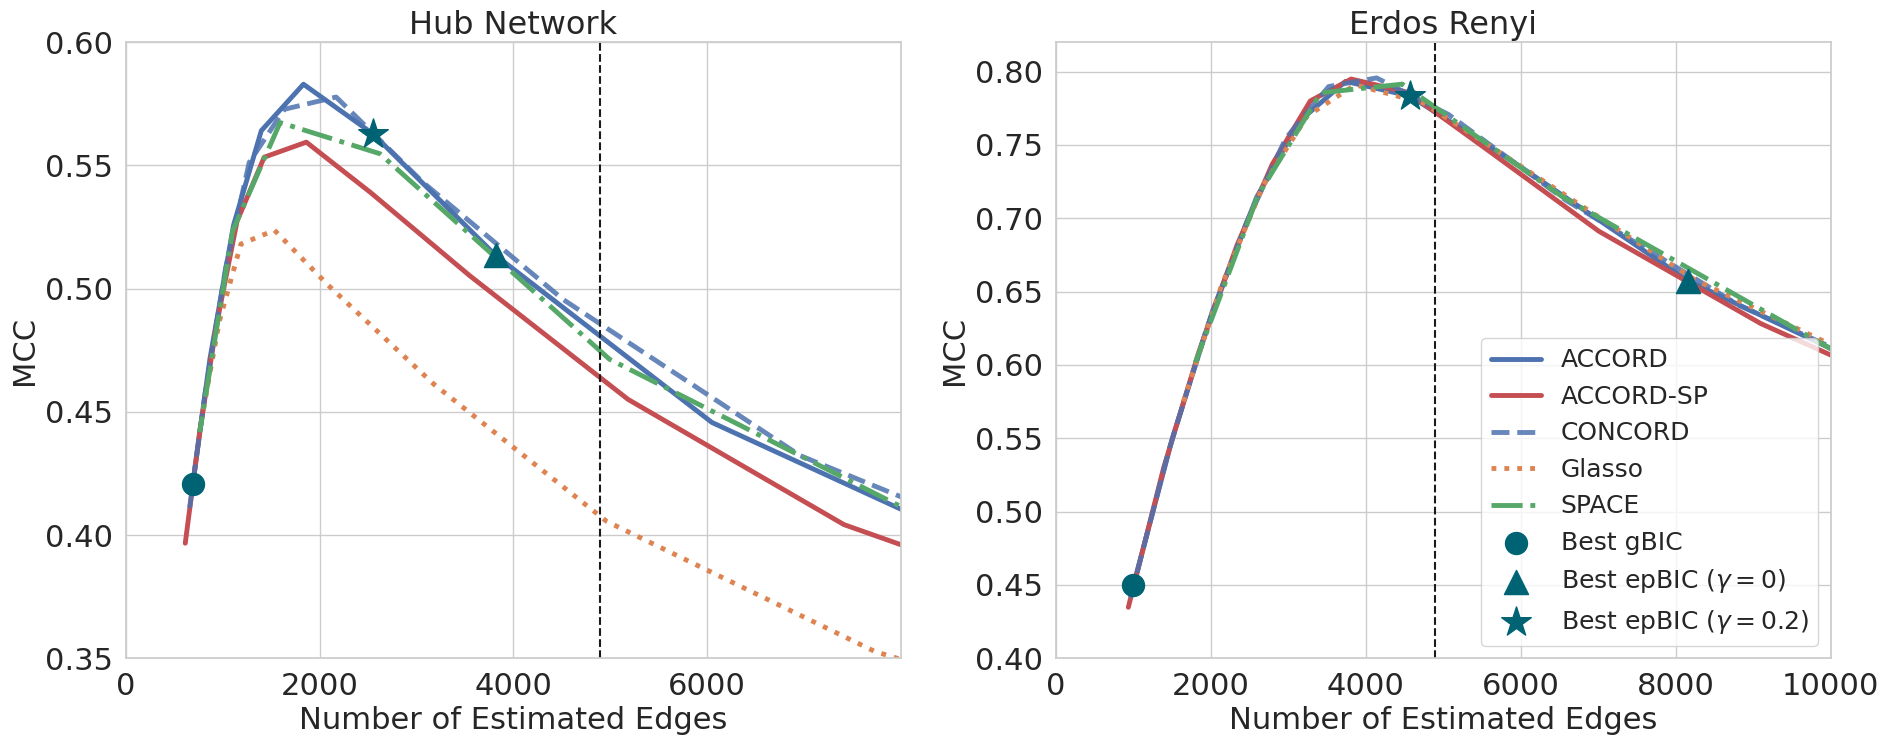

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

i = 0
axes[i].plot(accord_edges_hub, accord_mccs_hub, linewidth=3.5, color='C0', label='ACCORD')
# axes[i].plot(accord_sp_edges_hub, accord_sp_mccs_hub, linewidth=3.5, color='C3', label='ACCORD-SP')
axes[i].plot(concord_edges_hub, concord_mccs_hub, linewidth=3.5, linestyle='--', color='C0', alpha=0.85, label='CONCORD')
axes[i].plot(glasso_edges_hub, glasso_mccs_hub, linewidth=3.5, linestyle=':', color='C1', label='Glasso')
axes[i].plot(space_edges_hub, space_mccs_hub, linewidth=3.5, linestyle='-.', color='C2', label='SPACE')
axes[i].scatter(accord_edges_hub[best_g_bic_hub], accord_mccs_hub[best_g_bic_hub], marker='o', zorder=2, s=250, color=sns.color_palette('dark')[-1], label='Best gBIC')
axes[i].scatter(accord_edges_hub[best_p_bic_hub], accord_mccs_hub[best_p_bic_hub], marker='^', zorder=2, s=300, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0$)')
axes[i].scatter(accord_edges_hub[best_ep_bic_02_hub], accord_mccs_hub[best_ep_bic_02_hub], marker='*', zorder=2, s=500, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0.2$)')
axes[i].axvline((len(np.flatnonzero(Theta))-p)/2, linewidth=1.5, color='k', linestyle='--')
axes[i].set_title('Hub Network', fontsize=23)
axes[i].set_xlabel('Number of Estimated Edges', fontsize=22)
axes[i].set_ylabel('MCC', fontsize=22)
axes[i].tick_params(axis='both', which='major', labelsize=22)
axes[i].set_xlim((0,8000))
axes[i].set_ylim((0.35,0.6))
axes[i].set_xticks(np.arange(0, 8000, 2000))

i = 1
axes[i].plot(accord_edges_er, accord_mccs_er, linewidth=3.5, color='C0', label='ACCORD')
# axes[i].plot(accord_sp_edges_er, accord_sp_mccs_er, linewidth=3.5, color='C3', label='ACCORD-SP')
axes[i].plot(concord_edges_er, concord_mccs_er, linewidth=3.5, linestyle='--', color='C0', alpha=0.85, label='CONCORD')
axes[i].plot(glasso_edges_er, glasso_mccs_er, linewidth=3.5, linestyle=':', color='C1', label='Glasso')
axes[i].plot(space_edges_er, space_mccs_er, linewidth=3.5, linestyle='-.', color='C2', label='SPACE')
axes[i].scatter(accord_edges_er[best_g_bic_er], accord_mccs_er[best_g_bic_er], marker='o', zorder=2, s=250, color=sns.color_palette('dark')[-1], label='Best gBIC')
axes[i].scatter(accord_edges_er[best_p_bic_er], accord_mccs_er[best_p_bic_er], marker='^', zorder=2, s=300, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0$)')
axes[i].scatter(accord_edges_er[best_ep_bic_02_er], accord_mccs_er[best_ep_bic_02_er], marker='*', zorder=2, s=500, color=sns.color_palette('dark')[-1], label='Best epBIC ($\gamma=0.2$)')
axes[i].axvline((len(np.flatnonzero(Theta))-p)/2, linewidth=1.5, color='k', linestyle='--')
axes[i].set_title('Erdos Renyi', fontsize=23)
axes[i].set_xlabel('Number of Estimated Edges', fontsize=22)
axes[i].set_ylabel('MCC', fontsize=22)
axes[i].tick_params(axis='both', which='major', labelsize=22)
axes[i].set_xlim((0,10000))
axes[i].set_ylim((0.4,0.82))
axes[i].legend(fontsize=18, loc='lower right')

plt.savefig('../output/edge_detection.png', bbox_inches='tight');